In [2]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
import os
os.chdir('/content/drive/MyDrive/365 frontier ai/day 3/')

In [4]:
#read aall the words
words = open('names.txt', 'r').read().splitlines()
words[:5]

['emma', 'olivia', 'ava', 'isabella', 'sophia']

In [5]:
#build the vocabulary of  characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [6]:
#build the dataset

def build_dataset(words):
  block_size = 3 #context length
  X, Y = [], []
  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix]       #crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])


torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [7]:
Xtr.shape, Xtr.dtype, Xdev.shape, Xdev.dtype, Xte.shape, Xte.dtype

(torch.Size([182625, 3]),
 torch.int64,
 torch.Size([22655, 3]),
 torch.int64,
 torch.Size([22866, 3]),
 torch.int64)

In [8]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27,7), generator = g)
W1 = torch.randn((21,200), generator = g)
b1 = torch.randn(200, generator = g)
W2 = torch.randn((200,27),generator = g)
b2 = torch.randn(27, generator = g)
parameters = [C, W1, b1, W2, b2]

In [9]:
sum(p.nelement() for p in parameters)  #numbber of param in total

10016

In [10]:
for p in parameters:
  p.requires_grad = True

In [11]:
lri = []
lossi = []
stepi = []

In [38]:
for i in range(200000):
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (32,))

    # forward pass
    emb = C[Xtr[ix]]
    h = torch.tanh(emb.view(-1, 21) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Ytr[ix])

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.001
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    stepi.append(i)
    lossi.append(loss.log10().item())   # Fixed: loss, not lossi

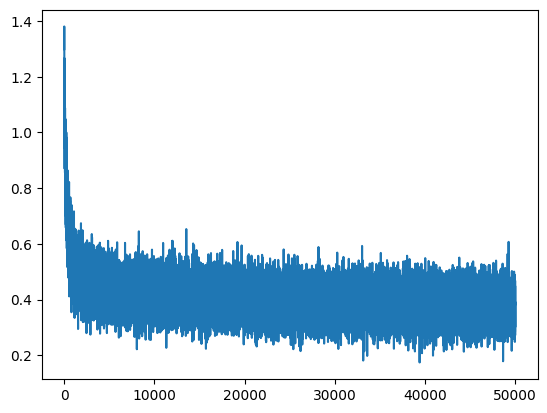

In [13]:
plt.plot(stepi, lossi)

In [39]:
emb = C[Xtr]
h = torch.tanh(emb.view(-1,21) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ytr)
loss

tensor(2.0957, grad_fn=<NllLossBackward0>)

In [40]:
emb = C[Xdev]
h = torch.tanh(emb.view(-1,21) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ydev)
loss

tensor(2.1511, grad_fn=<NllLossBackward0>)

In [41]:
#sample from the model

g = torch.Generator().manual_seed(2147483647 + 10)
block_size = 3

for _ in range(20):
  out = []
  context = [0] * block_size #initialize with all
  while True:
    emb = C[torch.tensor([context])]  #(1,block_size, d)
    h = torch.tanh(emb.view(1, -1) @ W1 + b1)
    logits = h @ W2 + b2
    probs = F.softmax(logits, dim=1)
    ix = torch.multinomial(probs, num_samples=1, generator=g).item()
    context = context[1:] + [ix]
    out.append(ix)
    if ix == 0:
      break

  print(''.join(itos[i] for i in out))

carmah.
amelle.
khi.
mili.
taty.
skaaden.
jazonte.
deliah.
jareei.
nellara.
chaiir.
kaleigh.
ham.
joce.
quintes.
lilea.
jadil.
wajero.
dearyxix.
kaeulias.


In [ ]:
#we plateued at about 2.09. which is not bad
#the overfiting here is less than 10 dimension but it plateues earlier
#so ig dimensions does help. probably giving more context.
#like increasing to 4 wud help. but i don't want to try anymore.
#i am tired for today.
#good experiment ngl